# Efficiency
## We cannot go above a specific memory usage (same as below?)
The amount of ads in the table is given by `d = xa/(a + w)`, where `x` is the number of requests constantly trying to get into the table, `a` is ad lifetime (the time spent in the table by each ad before being evicted) and `w` is the average waiting time received by the requests.

Assuming the worst case scenario, when the attacker is able to achieve 0 similarity score for both the topic and the IP addresses, the waiting time formula gives us: `w = (ba)/(1 - d/n)^P_occupancy`

Plugging that in into the previous equation, we get `d = xa/((a + (ba)/(1 - d/n)^P_occupancy)) = x/((1 + b/(1 - d/n)^P_occupancy))`.


Assuming an average size of an advertisement equal to 1KB we have `x ~= registrar_download_link_in_B / 1024`. 

In consultation with the Geth developers, we set up the capacity of the table to `n = 1000`. 

This gives us `d = (registrar_download_link_in_B / 1024)/((1 + b/(1 - d/1000)^P_occupancy))`

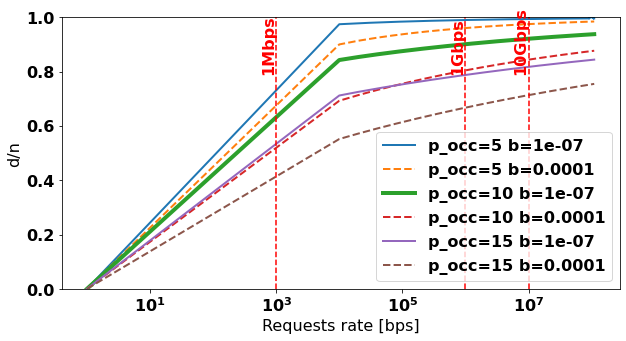

In [13]:
#!/usr/bin/python

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Define the expression whose roots we want to find
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
n = 1000

for p_occupancy in [5, 10, 15]:
    for b in [0.0000001, 0.0001]:
        x_vals = []
        y_vals = []

        for x in range(1, 110000000, 10000):
            func = lambda d: x/(1+ b/(1-(d)/n)**p_occupancy) - (d)
            d = np.linspace(0, 300, 300)

            # Use the numerical solver to find the roots
            d_initial_guess = 10
            d_solution = fsolve(func, d_initial_guess)

            x_vals.append(x)
            y_vals.append(d_solution/n)
        if(b == 0.0001):
            ax.plot(x_vals, y_vals, label='p_occ=' + str(p_occupancy) + " b=" + str(b), linestyle = "--", linewidth = 2)
        elif (p_occupancy == 10):
            ax.plot(x_vals, y_vals, label='p_occ=' + str(p_occupancy) + " b=" + str(b), linestyle = "-", linewidth = 4)
        else:
            ax.plot(x_vals, y_vals, label='p_occ=' + str(p_occupancy) + " b=" + str(b), linestyle = "-", linewidth = 2)

plt.ylabel("d/n")
plt.xlabel("Request rate [bps]")

plt.axvline(x=10000000, color='red', linestyle='--')
plt.annotate("10Gbps", xy = (10000000*0.75, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.axvline(x=1000000, color='red', linestyle='--')
plt.annotate("1Gbps", xy = (1000000*0.75, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.axvline(x=1000, color='red', linestyle='--')
plt.annotate("1Mbps", xy = (1000*0.75, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.xscale("log")
plt.ylim(0, 1)
plt.legend()
plt.show()

We want to:
* keep `d` as small as possible to prevent interference with the topic and IP scores
* use the space in the table even for low traffic
* make sure that we never go beyond 100% table capacity

As a result, we set `d = 10^-7` and `p_occupancy = 10`. For lower occupancies (e.g., `p_occupancy = 5`), it's theoretically possible to go beyond the capacity of the table. 

### TODO
@Ramin: Is it possible to calculate an asymptote the `d` goes toward based on `p_occupancy` and `b`? We could then have a much clearer graph and better motivation for the chosen values. 

## The state maintained by each registrar is bounded to `O(n)`
* We proved above that the size of the topic cash is limited with the right set of parameters
* The request received by each registrar do not create any state (apart from the lower bound) at the registrar (i.e., the registrar uniquely calculates the waiting time and return a signed ticket)
* The lower bound state create by registrars is bounded by the number of distinct IPs and topic in the cash and is thus bounded `O(n)`


## Both register and lookup operations finish within O(log(n)) steps
They both mimic MSG_FIND from regular DHT operations and thus inherits this property. 

### TODO
make sure we distinguish between `n` - number of nodes in the network and `n` - capacity of the ad cash.


# Fairness

## Register operations introduce an equal load on the registrars even with unequal popularity of the topics.

We assume a Zipf distribution of the topics in the system and that the topic hashes are uniformly distributed in the hash space. For simplicity we uniquely compare the load of `registrar A` - located close to the most popular `topic A` and the load of `registrar B` - located close to the least popular `topic B`. There are `n` nodes in the network, `topic A` is followed by `n_a` nodes and `topic B` is followed by `n_b` nodes, where `n_a >> n_b`. 

Let us assume that `topic A` and `topic B` are located on the oposite part of the hashspace (the worst case scenario for load balancing) and that both `registrar A` and `registrar B` receive the same amount of traffic `L_X` from other topic `topic X != topic A and  topic X != topic B`. 

`registrar A` will receive registration requests from `B_A = n_a/max(1, n/2^17) ~= n_a` (for any reasonable size of `n`) nodes for `topic A` and `B_B = (n_b*K_register)/(n/2)` request for `topic B`. That gives us the total load on `registrar_A` equal to `L_A = L_X + n_a + (n_b*K_register)/(n/2)`. 

Similarely, the total load on `registrar_B` is equal to `L_B = L_X + n_b + (n_a*K_register)/(n/2)`. 

A:  500 [4.68320796e+01 1.92353696e-01 3.00832764e+02]    B:  500 [1.92353696e-01 4.68320796e+01 3.00832764e+02]
A:  1000 [6.46767048e+01 1.91775104e-01 2.89275996e+02]    B:  500 [  0.37146616  46.81623823 300.72660149]
A:  1500 [7.74757793e+01 1.91323481e-01 2.81045725e+02]    B:  500 [  0.53972418  46.80135738 300.62687949]
A:  2000 [8.77192086e+01 1.90937901e-01 2.74495794e+02]    B:  500 [  0.69887351  46.78728258 300.53256183]
A:  2500 [9.63608669e+01 1.90594700e-01 2.68996507e+02]    B:  500 [  0.85023679  46.7738968  300.44286375]
A:  3000 [1.03884829e+02 1.90281716e-01 2.64228736e+02]    B:  500 [  0.99484458  46.76110884 300.3571738 ]
A:  3500 [1.10575769e+02 1.89991710e-01 2.60005048e+02]    B:  500 [  1.13351834  46.74884601 300.27500456]
A:  4000 [1.16617382e+02 1.89719958e-01 2.56204647e+02]    B:  500 [  1.26692549  46.73704927 300.19595999]
A:  4500 [1.22136077e+02 1.89463175e-01 2.52744504e+02]    B:  500 [  1.3956169   46.72566981 300.11971341]
A:  5000 [1.27223064e+0

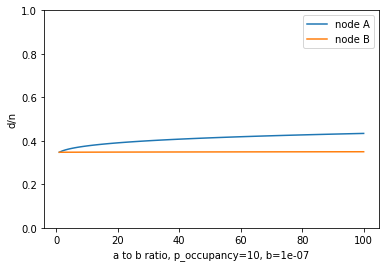

In [9]:
#!/usr/bin/python

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

fig = plt.figure()
ax = fig.add_subplot()

n = 1000             # Table capacity
p_occupancy = 10
b = 0.0000001

N = 25000            # Network size
K_register = 5       # Number of registrations per bucket
N_A = 20             # Number of advertisers for topic A (will be overwritten in the for loop below)
N_B = 500           # Number of advertisers for topic B
R_X = 19000            # Background number of registrations

x_vals = []
y_vals_A = []
y_vals_B = []

# The d equations for registrar close to topic A.
# This ignores the IP score, assuming that it is 0 ("worst case" of perfectly balanced addresses)
def equations_A(dvec):
    d_a = dvec[0]
    d_b = dvec[1]
    d_x = dvec[2]
    d = d_a + d_b + d_x
    t = 1 / (1 - d/n)**p_occupancy
    # Number of registrations that this registrar will get for topic A and B
    R_A = N_A
    R_B = K_register* N_B / (N/2)
    return [ R_A / (1+(b+d_a/d)*t) - d_a , R_B / (1+(b+d_b/d)*t) - d_b , R_X / (1+(b+d_x/d)*t) - d_x ]

def equations_B(dvec):
    d_a = dvec[0]
    d_b = dvec[1]
    d_x = dvec[2]
    d = d_a + d_b + d_x
    t = 1 / (1 - d/n)**p_occupancy
    # Number of registrations that this registrar will get for topic A and B
    R_A = K_register* N_A / (N/2)
    R_B = N_B
    return [ R_A / (1+(b+d_a/d)*t) - d_a , R_B / (1+(b+d_b/d)*t) - d_b , R_X / (1+(b+d_x/d)*t) - d_x ]

for a_to_b_ratio in range(1, 101):
    # Number of advertisers for topic A
    N_A = a_to_b_ratio * N_B

    x_vals.append(a_to_b_ratio)
    
    # This seems to be very sensitive to the initial guess!
    
    dvec_solutionA = fsolve(equations_A, [100,100,50])
    d_solutionA = dvec_solutionA[0]+dvec_solutionA[1]+dvec_solutionA[2]
    y_vals_A.append(d_solutionA/n)
    
    dvec_solutionB = fsolve(equations_B, [100,300,50])
    d_solutionB = dvec_solutionB[0]+dvec_solutionB[1]+dvec_solutionB[2]
    y_vals_B.append(d_solutionB/n)
    print("A: ",N_A,dvec_solutionA, "   B: ",N_B,dvec_solutionB)
    
ax.plot(x_vals, y_vals_A, label="node A")
ax.plot(x_vals, y_vals_B, label="node B")

plt.ylabel("d/n")
plt.xlabel("a to b ratio, p_occupancy=" + str(p_occupancy) + ", b=" + str(b))

plt.ylim(0, 1)
plt.legend()
plt.show()

## Lookup operations introduce an equal load on the registrars even with unequal popularity of the topics.
We're interested in the number of lookups both registrars receive. We ignore the background traffic, as it should be the same for both registrars. 

The amount of traffic is given by the number of searchers for both topics `n_a` and `n_b` and their probability of reaching the last bucket `P_reach_a` and `P_reach_b`. 

To calculate `P_reach_a`, we need:
* The distribution of the number of ads for given topic on registrars in each bucket `d_a_i`. We can get the average number of ads, but what kind of distribution can we assume here (is normal a good guess - can we justify it)?
* Once having the distribution (per bucket)

Useful resources:
* https://mathworld.wolfram.com/UniformSumDistribution.html
* This seems as exactly something we need (assuming normal distribution) - https://math.stackexchange.com/questions/3544099/how-many-normal-distribution-random-numbers-sum-exceeds-r






# Security

## Probability probability of a lookup operation being eclipsed

We need: 
* probability of receiving uniquely malicious ads from an honest registrar in bucket `i`: `P_h_eclipse_i`
* probability of encountering a malicious node in a specific bucket (e.g., it's gonna be `n_malicious/n` for the uniform distribution of the malicious nodes) `P_a_i` (`P_h_i = 1 - P_a_i`)

With this, we can calculate the probability of receiving uniquely malicious ads from a random node in bucket `i`. This is given by `P_random_eclipse_i = P_a_i + P_h_i * P_h_eclipse_i`

The probability of being eclipsed in a bucket after asking `K_lookup` registrars is given by: `P_eclipse_i = P_random_eclipse_i ^ K_lookup`

Finally, the probability of being entirely eclipsed is given by: `P_eclipse = sum_i:0-17(P_eclipse_i)`


To calculate `P_h_eclipse_i` we require:
* The number of honest advertiser per honest registrars in bucket `i`, `n_honest_i` - this is given by `min(n_honest, (n_honest*K_register)/(n/2^i))`
* The number of malcious advertiser per honest registrars in bucket `i`,  `n_malicious_i` - this is given by `min(n_malicious, (n_malicious*K_register)/(n/2^i))`, we can set the K_register to higher values
* The number of IP addresses that the malicious users have `n_malicious_ip_i`
* The number of ads in the table unrelated to the topic `d_x_i` - cab it be fixed for simplicity?

P_h_eclipse: 0
P_random_eclipse_i: 0.02 K_lookup: 5
funcs, d_a: 10 d_h: 10
n: 10 a: 0 k: 10.0
funcs, d_a: 10.0 d_h: 10.0
n: 10.0 a: 0 k: 10.0
funcs, d_a: 10.0 d_h: 10.0
n: 10.0 a: 0 k: 10.0
funcs, d_a: 10.000000149011612 d_h: 10.0
n: 10.0 a: 0 k: 10.000000149011612
funcs, d_a: 10.0 d_h: 10.000000149011612
n: 10.000000149011612 a: 0 k: 10.0
funcs, d_a: 9.663816191465369 d_h: 169.38312421041746
n: 169.38312421041746 a: 0 k: 9.663816191465369
funcs, d_a: 9.774776564941586 d_h: 45.41175164482033
n: 45.41175164482033 a: 0 k: 9.774776564941586
funcs, d_a: 10.000000149011612 d_h: 10.0
n: 10.0 a: 0 k: 10.000000149011612
funcs, d_a: 10.0 d_h: 10.000000149011612
n: 10.000000149011612 a: 0 k: 10.0
funcs, d_a: 9.663816191465369 d_h: 169.38312421041746
n: 169.38312421041746 a: 0 k: 9.663816191465369
funcs, d_a: 9.774776564941586 d_h: 45.41175164482033
n: 45.41175164482033 a: 0 k: 9.774776564941586
funcs, d_a: 9.882205485777321 d_h: 16.530241485743417
n: 16.530241485743417 a: 0 k: 9.882205485777321


/tmp/ipykernel_12550/1849871790.py:24: RuntimeWarning: overflow encountered in double_scalars
  result += scipy.special.comb(m,i) / 2**m
/tmp/ipykernel_12550/1849871790.py:24: RuntimeWarning: invalid value encountered in double_scalars
  result += scipy.special.comb(m,i) / 2**m
/tmp/ipykernel_12550/1849871790.py:27: RuntimeWarning: overflow encountered in double_scalars
  result -= scipy.special.comb(m,i) / 2**m
/tmp/ipykernel_12550/1849871790.py:27: RuntimeWarning: invalid value encountered in double_scalars
  result -= scipy.special.comb(m,i) / 2**m


ValueError: cannot convert float NaN to integer

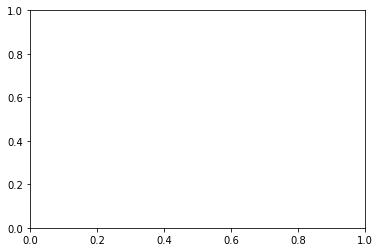

In [1]:
#!/usr/bin/python

## The code below is currently not working

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.special
import math

#constants
P_occ = 10

g_x_h = None #the number of honest registrants
g_x_a = None #the number of malicious registrants
g_ip_num_a = None #the number of distinct IPs at attacker disposal
g_others = None #the number of other requests in the table


def p(m,b):
    b = int(b)
    result = 0
    for i in range(b,int(m)+1):
        result += scipy.special.comb(m,i) / 2**m
    result += 1
    for i in range(0, b):
        result -= scipy.special.comb(m,i) / 2**m
    return result/2  

def ip_score_h(d_h, d_a, ip_num_a):
    n = d_h
    k = d_a/ip_num_a
    a = int(math.log(ip_num_a, 2))

    result = 0
    total = n+2**a*k
    for i in range (1,a+1):
        m = n / 2**(i-1)
        b = int(total/2**i)+1
        result += p(m, b-2**(a-i)*k)
    for i in range(a+1, 33):
        m = n / 2**(i-1)
        b = int(total/2**i)+1
        result += 1/2**(i-a) * p(m, b-k)
        result += (1-1/2**(i-a)) * p(m, b)
    return result/32


def ip_score_a(d_h, d_a, ip_num_a):
    n = d_h
    k = d_a/ip_num_a
    a = int(math.log(ip_num_a, 2))

    result = 0
    total = n+2**a*k
    print("n:", n, "a:", a, "k:", k)
    for i in range (1,a+1):
        m = n / 2**(i-1)
        print("total:", total, "i:", i)
        b = int(total/2**i)+1
        result += p(m, b-2**(a-i)*k)
    for i in range(a+1, 33):
        m = n / 2**(i-1)
        b = int(total/2**i)+1
        result += p(m, b-k)
    return result/32

def func(var):
    d_a = var[0] #attacker in the table
    d_h = var[1] #honest in the table
    f = np.zeros(2)
    print("funcs, d_a:", d_a, "d_h:", d_h)
    f[0] = g_x_a / (1 + (((d_a + d_h)/(d_a + d_h + g_others)) + ip_score_a(d_h, d_a, g_ip_num_a))/(1-(d_a + d_h)/n)**P_occ) - d_a
    f[1] = g_x_h / (1 + (((d_a + d_h)/(d_a + d_h + g_others)) + ip_score_h(d_h, d_a, g_ip_num_a))/(1-(d_a + d_h)/n)**P_occ) - d_h
    return f

#the probability of being eclipse when asking a single honest registrar
def single_registrar_eclipse_probability(x_h, x_a, others, ip_num_a, n_lookup):
    global g_x_h, g_x_a, g_others, g_ip_num_a
    g_x_h = x_h #the number of honest advertisers
    g_x_a = x_a #the number of malicious advertisers
    g_others = others #the number of other requests in the table
    g_ip_num_a = ip_num_a #the number of distinct IP addresses at attacker's disposal

    d_initial_guess = (10, 10)
    d_solution = fsolve(func, d_initial_guess)
    d_a = int(d_solution[0])# num of malicious ads in the table
    d_h = int(d_solution[1])# num of honest ads in the table

    #each searchers asks for n_lookup peer nodes from the table
    #this is similar to drawing cards without returning
    #see https://study.com/skill/learn/calculating-probabilities-of-draws-without-replacement-explanation.html
    P_eclipsed = 1
    for i in range(0, n_lookup):
        #stop if we don't have any additional ads left
        if((d_a + d_h - i) == 0):
            break
        P_eclipsed *= (d_a - i) / (d_a + d_h - i)

    print("returning;: P_eclipse:", P_eclipsed)
    return P_eclipsed
    
#i - the bucket number
#n - the number of all the nodes in the network
#n_honest - the number of honest advertisers in the network
#K_register - the number of registrations each honest advertisers performs per bucket
#n_malicious - the number of malicious advertisers in the network
#K_register_malicious - the number of registrations each malicious advertisers performs per bucket
#others - the number of other requests in the table (we assume it's the same for all the registrars)
#n_malicious_ip - the number of distinct IP addresses available global for malicious nodes
#n_lookup - searchers asks for n_lookup peer nodes from the cache
def P_h_eclipse(n, n_honest, K_register, n_malicious, K_register_malicious, i, others, n_malicious_ip, n_lookup):
    x_h = min(n_honest, (n_honest*K_register)/(n/(2**i)))
    x_a = min(n_malicious, (n_malicious*K_register_malicious)/(n/(2**i)))
    #print("i", i, "x_a", x_a, "x_h", x_h, "n_malicious_ip", n_malicious_ip, "n_malicious", n_malicious)
    if(int(x_a) == 0):
        return 0
    
    ip_num_a = max(1, int(n_malicious_ip*x_a /n_malicious)) #the malicious advertisers in question receive a proportional number of IP addresses
    
    print("single_registrar_eclipse_probability(x_h, x_a, others, ip_num_a, n_lookup):", single_registrar_eclipse_probability(x_h, x_a, others, ip_num_a, n_lookup))
    return single_registrar_eclipse_probability(x_h, x_a, others, ip_num_a, n_lookup)

#the probability of being eclipse in a specific bucket
def P_eclipse_i(n, n_honest, K_register, n_malicious, K_register_malicious, i, others, n_malicious_ip, n_lookup, K_lookup):
    P_a_i  = n_malicious / n
    P_h_i = (n - n_malicious) / n
    
    print("P_h_eclipse:", P_h_eclipse(n, n_honest, K_register, n_malicious, K_register_malicious, i, others, n_malicious_ip, n_lookup))
    P_random_eclipse_i = P_a_i + P_h_i * P_h_eclipse(n, n_honest, K_register, n_malicious, K_register_malicious, i, others, n_malicious_ip, n_lookup)
    print("P_random_eclipse_i:", P_random_eclipse_i, "K_lookup:", K_lookup)
    return P_random_eclipse_i ** K_lookup


def P_eclipse(n, n_honest, K_register, n_malicious, K_register_malicious, others, n_malicious_ip, n_lookup, K_lookup):
    result = 1
    for i in range(1, 12):
        result *= P_eclipse_i(n, n_honest, K_register, n_malicious, K_register_malicious, i, others, n_malicious_ip, n_lookup, K_lookup)
    return result

fig = plt.figure()
ax = fig.add_subplot()
x_vals = []
y_vals = []
#for n_malicious in range(1, 500, 10):
n = 25000 #the number of all the nodes in the network
n_malicious = 500
n_honest = n - n_malicious
K_register = 5
K_register_malicious = 15
others = 0
n_malicious_ip = 50
n_lookup = 10
K_lookup = 5
    
y_val = P_eclipse(n, n_honest, K_register, n_malicious, K_register_malicious, others,n_malicious_ip, n_lookup, K_lookup)
assert(y_val != None)
print("Eclipse probability for ", n_malicious, "malicious nodes is", y_val)
x_vals.append(n_malicious)
y_vals.append(y_val)


    
#ax.plot(x_vals, y_vals, color='red')

plt.ylabel("Lookup eclipse proability")
plt.xlabel("n_malicious")
plt.legend()
plt.show()